In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
def eval_model(test,pred,model_name):
    mae = mean_absolute_error(test,pred)
    mse = mean_squared_error(test,pred)
    rmse = np.sqrt(mean_squared_error(test,pred))
    mape = mean_absolute_percentage_error(test,pred)
    res = pd.DataFrame({'MAE':mae,'MSE':mse,'RMSE':rmse,'MAPE':mape},
                       index=[model_name])
    return res

def plot_res(train,test,fcast):  # fcast = forecast
    plt.plot(train,label='Train',color='blue')
    plt.plot(test,label='Test',color='orange')
    plt.plot(fcast,label='fcast',color='green')
    plt.legend()
    plt.show()
    
def adf_test(data):
    res = adfuller(data)
    print('ADF Statistic:',res[0])
    print('p-value:',res[1])
    if res[1]>0.05:
        print('Ho accpeted - Data is not stationary')
    else:
        print('H1 accpeted - Data is stationary')    
        
def arima_fun(p,d,q,model_name):
    model = ARIMA(np.log(train), order=(p,d,q))
    arima_fit = model.fit()
    fcast_arima = np.exp(arima_fit.forecast(test.shape[0]))
    print(fcast_arima)
    plot_res(train,test,fcast_arima)
    model_res = eval_model(test,fcast_arima,model_name)
    return model_res

#### Read the dataset

In [21]:
df = pd.read_csv('Super_Store_data.csv',encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [22]:
df = df[['Order Date','Sales']]
df.head()

,Order Date,Sales
0,11/8/2016,261.9600
1,11/8/2016,731.9400
2,10/11/2015,957.5775
3,6/9/2014,48.8600
4,6/9/2014,1706.1840


In [23]:
df.dtypes

Order Date     object
Sales         float64
dtype: object

In [24]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.dtypes

Order Date    datetime64[ns]
Sales                float64
dtype: object

In [25]:
df.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
2,2015-10-11,957.5775
3,2014-06-09,48.8600
4,2014-06-09,1706.1840


In [26]:
df.sort_values('Order Date',inplace=True)
df.head(10)

,Order Date,Sales
1577,2014-01-06,2573.820
1626,2014-01-07,76.728
181,2014-01-10,51.940
150,2014-01-11,9.940
631,2014-01-13,545.940
1024,2014-01-13,333.999
1355,2014-01-14,61.960
200,2014-01-16,127.104
1131,2014-01-19,181.470
1326,2014-01-20,272.940


In [27]:
df['Order Date'].value_counts()

2016-09-05    10
2016-12-25     9
2016-12-01     9
2017-11-19     9
2017-10-30     9
              ..
2015-11-26     1
2015-11-24     1
2015-11-22     1
2015-11-19     1
2017-12-30     1
Name: Order Date, Length: 889, dtype: int64

In [30]:
df = df.groupby('Order Date')['Sales'].sum().to_frame()
df

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
...,...
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568


In [31]:
df['Order Date'] = df.index
df.head()

,Sales,Order Date
Order Date,,
2014-01-06,2573.820,2014-01-06
2014-01-07,76.728,2014-01-07
2014-01-10,51.940,2014-01-10
2014-01-11,9.940,2014-01-11
2014-01-13,879.939,2014-01-13


In [32]:
df['Order Date'].value_counts()

2014-01-06    1
2016-11-23    1
2016-11-10    1
2016-11-11    1
2016-11-12    1
             ..
2015-08-02    1
2015-08-05    1
2015-08-06    1
2015-08-07    1
2017-12-30    1
Name: Order Date, Length: 889, dtype: int64

In [33]:
df['Order Date'].head(20)

Order Date
2014-01-06   2014-01-06
2014-01-07   2014-01-07
2014-01-10   2014-01-10
2014-01-11   2014-01-11
2014-01-13   2014-01-13
2014-01-14   2014-01-14
2014-01-16   2014-01-16
2014-01-19   2014-01-19
2014-01-20   2014-01-20
2014-01-21   2014-01-21
2014-01-26   2014-01-26
2014-01-27   2014-01-27
2014-01-31   2014-01-31
2014-02-08   2014-02-08
2014-02-11   2014-02-11
2014-02-12   2014-02-12
2014-02-18   2014-02-18
2014-02-20   2014-02-20
2014-03-01   2014-03-01
2014-03-03   2014-03-03
Name: Order Date, dtype: datetime64[ns]

In [34]:
df1 = df.copy()

In [36]:
# df1.drop('Order Date',axis=1,inplace=True)
# df1.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [37]:
df.head()

,Sales,Order Date
Order Date,,
2014-01-06,2573.820,2014-01-06
2014-01-07,76.728,2014-01-07
2014-01-10,51.940,2014-01-10
2014-01-11,9.940,2014-01-11
2014-01-13,879.939,2014-01-13


In [38]:
df2 = df.copy()

In [39]:
df.shape

(889, 2)

In [41]:
df2.index =list(range(889))
df2 = df2[['Order Date','Sales']]
df2.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [46]:
df3 = df['Sales'].resample('MS').mean().to_frame()
df3.head()

,Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049188


In [47]:
df3.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Order Date', freq='MS')

In [48]:
df3.shape

(48, 1)

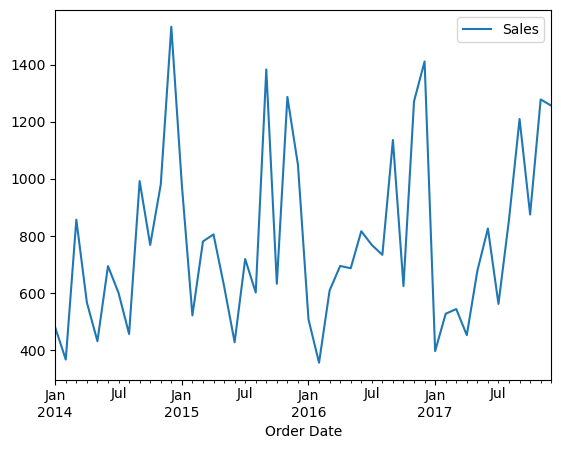

In [49]:
df3.plot()
plt.show()

In [55]:
adf_test(df3)
# d=0

ADF Statistic: -5.191070187339277
p-value: 9.16875665566545e-06
H1 accpeted - Data is stationary


In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

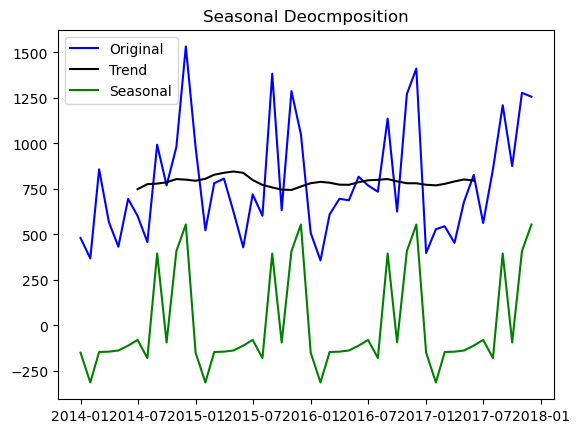

In [57]:
decom = seasonal_decompose(df3,model='additive')

original = decom.observed
trend = decom.trend
seasonal = decom.seasonal

plt.plot(original,label='Original',color='blue')
plt.plot(trend,label='Trend',color='black')
plt.plot(seasonal,label='Seasonal',color='green')
plt.title('Seasonal Deocmposition')
plt.legend()
plt.show()